# MODEL BUILDING
In this section we will create a LightGBM model. It will be evaluated with a RMSE metric.

We will optimize hyperparameters of the model based on the following 2 steps:
* optimization based on all the features,
* optimization based on half of the most important features selected from the previous best model

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from random import choice, randint, uniform

In [2]:
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
pd.set_option('mode.chained_assignment', None)

In [3]:
train = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')

Let's first establish a benchmark for our model. We will predict arrival delay with values of departure delay. Before that let's also create a function for RMSE estimation.

In [4]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [5]:
print('RMSE on train set:', rmse(train.DEPARTURE_DELAY, train.ARRIVAL_DELAY))
print('RMSE on test set:', rmse(test.DEPARTURE_DELAY, test.ARRIVAL_DELAY))

RMSE on train set: 14.366418544083855
RMSE on test set: 13.479669987438855


The values of arrival delay in train set are averagely different by about 14 minutes and 20 seconds, whereas RMSE for test set is about 13.5. It means that arrival delay in the test set is more similar to departure delay than in the train set.

Let's now determine categorical variables of our data and encode them as digits.

In [6]:
categorical = ['DAY_OF_WEEK', 'AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
              'STATE_ORIGIN', 'STATE_DESTINATION', 'SCHEDULED_DEPARTURE_HH', 'SCHEDULED_ARRIVAL_HH',
               'ROUTE', 'ROUTE_STATES', 'AIRLINE_ROUTE', 'AIRLINE_FLIGHT_NUMBER_ROUTE']

In [7]:
for col in categorical:
    le = LabelEncoder()
    le.fit((list(train[col].astype(str).values)) + list(test[col].astype(str).values))
    train[col] = le.transform(list(train[col].astype(str).values))
    test[col] = le.transform(list(test[col].astype(str).values))

In [8]:
train.shape, test.shape

((1356814, 110), (479251, 110))

In [9]:
train.head()

,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,DISTANCE,ARRIVAL_DELAY,STATE_ORIGIN,LATITUDE_ORIGIN,LONGITUDE_ORIGIN,STATE_DESTINATION,LATITUDE_DESTINATION,LONGITUDE_DESTINATION,SCHEDULED_DEPARTURE_HH,SCHEDULED_ARRIVAL_HH,ROUTE,ROUTE_STATES,ORIGIN_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN,ORIGIN_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN,DESTINATION_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN,DESTINATION_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN,AIRLINE_DELAY_REDUCTION_1_HOURS_MEAN,AIRLINE_DELAY_REDUCTION_5_HOURS_MEAN,ROUTE_STATES_DELAY_REDUCTION_1_HOURS_MEAN,ROUTE_STATES_DELAY_REDUCTION_5_HOURS_MEAN,ROUTE_DELAY_REDUCTION_1_HOURS_MEAN,ROUTE_DELAY_REDUCTION_5_HOURS_MEAN,TAIL_NUMBER_DELAY_REDUCTION_1_HOURS_MEAN,TAIL_NUMBER_DELAY_REDUCTION_5_HOURS_MEAN,ORIGIN_AIRPORT_DELAY_REDUCTION_24_HOURS_MEAN,DESTINATION_AIRPORT_DELAY_REDUCTION_24_HOURS_MEAN,AIRLINE_DELAY_REDUCTION_24_HOURS_MEAN,ROUTE_STATES_DELAY_REDUCTION_24_HOURS_MEAN,ROUTE_DELAY_REDUCTION_24_HOURS_MEAN,TAIL_NUMBER_DELAY_REDUCTION_24_HOURS_MEAN,AIRLINE_ROUTE,AIRLINE_FLIGHT_NUMBER_ROUTE,AIRLINE_ROUTE_DELAY_REDUCTION_1_HOURS_MEAN,AIRLINE_ROUTE_DELAY_REDUCTION_5_HOURS_MEAN,AIRLINE_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN,DESTINATION_AIRPORT_TAXI_IN_1_HOURS_MEAN,DESTINATION_AIRPORT_TAXI_IN_5_HOURS_MEAN,DESTINATION_AIRPORT_TAXI_IN_24_HOURS_MEAN,PERC_OF_INCREASED_DEL_ORIGIN_AIRPORT,PERC_OF_INCREASED_DEL_DESTINATION_AIRPORT,PERC_OF_INCREASED_DEL_AIRLINE,PERC_OF_INCREASED_DEL_ROUTE_STATES,PERC_OF_INCREASED_DEL_ROUTE,PERC_OF_INCREASED_DEL_TAIL_NUMBER,PERC_OF_INCREASED_DEL_SCHEDULED_DEPARTURE_HH,PERC_OF_INCREASED_DEL_SCHEDULED_ARRIVAL_HH,PERC_OF_INCREASED_DEL_AIRLINE_ROUTE,PERC_OF_INCREASED_DEL_AIRLINE_FLIGHT_NUMBER_ROUTE,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_ROLLING_1_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_ROLLING_3_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_ROLLING_7_MEAN,ORIGIN_AIRPORT_TAXI_OUT_1_HOURS_MEAN,ORIGIN_AIRPORT_TAXI_OUT_5_HOURS_MEAN,ORIGIN_AIRPORT_TAXI_OUT_24_HOURS_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_IN_ROLLING_1_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_IN_ROLLING_3_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_IN_ROLLING_7_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_OUT_ROLLING_1_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_OUT_ROLLING_3_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_OUT_ROLLING_7_MEAN,TAIL_NUMBER_DELAY_REDUCTION_ROLLING_1_MEAN,TAIL_NUMBER_DELAY_REDUCTION_ROLLING_3_MEAN,TAIL_NUMBER_DELAY_REDUCTION_ROLLING_7_MEAN,ORIGIN_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,AIRLINE_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,ROUTE_STATES_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,ROUTE_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,TAIL_NUMBER_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,AIRLINE_ROUTE_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_TAXI_IN_1_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_TAXI_OUT_1_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,AIRLINE_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,ROUTE_STATES_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,ROUTE_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,TAIL_NUMBER_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,AIRLINE_ROUTE_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_TAXI_IN_5_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_TAXI_OUT_5_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,AIRLINE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,ROUTE_STATES_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,ROUTE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,TAIL_NUMBER_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,AIRLINE_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_TAXI_IN_24_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_TAXI_OUT_24_HOURS_MEAN_DIFF,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_ROLLING_1_MEAN_DIFF,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_IN_ROLLING_1_MEAN_DIFF,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_OUT_ROLLING_1_MEAN_DIFF,TAIL_NUMBER_DELAY_RED

In [10]:
test.head()

,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,DISTANCE,ARRIVAL_DELAY,STATE_ORIGIN,LATITUDE_ORIGIN,LONGITUDE_ORIGIN,STATE_DESTINATION,LATITUDE_DESTINATION,LONGITUDE_DESTINATION,SCHEDULED_DEPARTURE_HH,SCHEDULED_ARRIVAL_HH,ROUTE,ROUTE_STATES,ORIGIN_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN,ORIGIN_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN,DESTINATION_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN,DESTINATION_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN,AIRLINE_DELAY_REDUCTION_1_HOURS_MEAN,AIRLINE_DELAY_REDUCTION_5_HOURS_MEAN,ROUTE_STATES_DELAY_REDUCTION_1_HOURS_MEAN,ROUTE_STATES_DELAY_REDUCTION_5_HOURS_MEAN,ROUTE_DELAY_REDUCTION_1_HOURS_MEAN,ROUTE_DELAY_REDUCTION_5_HOURS_MEAN,TAIL_NUMBER_DELAY_REDUCTION_1_HOURS_MEAN,TAIL_NUMBER_DELAY_REDUCTION_5_HOURS_MEAN,ORIGIN_AIRPORT_DELAY_REDUCTION_24_HOURS_MEAN,DESTINATION_AIRPORT_DELAY_REDUCTION_24_HOURS_MEAN,AIRLINE_DELAY_REDUCTION_24_HOURS_MEAN,ROUTE_STATES_DELAY_REDUCTION_24_HOURS_MEAN,ROUTE_DELAY_REDUCTION_24_HOURS_MEAN,TAIL_NUMBER_DELAY_REDUCTION_24_HOURS_MEAN,AIRLINE_ROUTE,AIRLINE_FLIGHT_NUMBER_ROUTE,AIRLINE_ROUTE_DELAY_REDUCTION_1_HOURS_MEAN,AIRLINE_ROUTE_DELAY_REDUCTION_5_HOURS_MEAN,AIRLINE_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN,DESTINATION_AIRPORT_TAXI_IN_1_HOURS_MEAN,DESTINATION_AIRPORT_TAXI_IN_5_HOURS_MEAN,DESTINATION_AIRPORT_TAXI_IN_24_HOURS_MEAN,PERC_OF_INCREASED_DEL_ORIGIN_AIRPORT,PERC_OF_INCREASED_DEL_DESTINATION_AIRPORT,PERC_OF_INCREASED_DEL_AIRLINE,PERC_OF_INCREASED_DEL_ROUTE_STATES,PERC_OF_INCREASED_DEL_ROUTE,PERC_OF_INCREASED_DEL_TAIL_NUMBER,PERC_OF_INCREASED_DEL_SCHEDULED_DEPARTURE_HH,PERC_OF_INCREASED_DEL_SCHEDULED_ARRIVAL_HH,PERC_OF_INCREASED_DEL_AIRLINE_ROUTE,PERC_OF_INCREASED_DEL_AIRLINE_FLIGHT_NUMBER_ROUTE,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_ROLLING_1_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_ROLLING_3_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_ROLLING_7_MEAN,ORIGIN_AIRPORT_TAXI_OUT_1_HOURS_MEAN,ORIGIN_AIRPORT_TAXI_OUT_5_HOURS_MEAN,ORIGIN_AIRPORT_TAXI_OUT_24_HOURS_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_IN_ROLLING_1_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_IN_ROLLING_3_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_IN_ROLLING_7_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_OUT_ROLLING_1_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_OUT_ROLLING_3_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_OUT_ROLLING_7_MEAN,TAIL_NUMBER_DELAY_REDUCTION_ROLLING_1_MEAN,TAIL_NUMBER_DELAY_REDUCTION_ROLLING_3_MEAN,TAIL_NUMBER_DELAY_REDUCTION_ROLLING_7_MEAN,ORIGIN_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,AIRLINE_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,ROUTE_STATES_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,ROUTE_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,TAIL_NUMBER_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,AIRLINE_ROUTE_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_TAXI_IN_1_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_TAXI_OUT_1_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,AIRLINE_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,ROUTE_STATES_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,ROUTE_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,TAIL_NUMBER_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,AIRLINE_ROUTE_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_TAXI_IN_5_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_TAXI_OUT_5_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,AIRLINE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,ROUTE_STATES_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,ROUTE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,TAIL_NUMBER_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,AIRLINE_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_TAXI_IN_24_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_TAXI_OUT_24_HOURS_MEAN_DIFF,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_ROLLING_1_MEAN_DIFF,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_IN_ROLLING_1_MEAN_DIFF,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_OUT_ROLLING_1_MEAN_DIFF,TAIL_NUMBER_DELAY_RED

We will use random search for parameters optimization. It will enable us to easy choose different sets of parameters with a better efficency than grid search.

We don't want our model to execute too long so let's fix a learning rate at 0.1. We will also fix an early stopping round parameter which will enable an algorithm to stop training when the performance of the model decreases on the cross-validated sets.  

Let's start with creating 50 different models.

In [61]:
%%time
num_boost_round = 300
iterations = 50

iters = []
rmse_results = []
dict_list = []

for i in range(iterations):
    print('Iteration', i+1)
    params = {'boosting': ['gbdt'],
         'num_leaves': randint(30, 120),
         'max_depth': choice([5, 6, 7]),
         'min_child_weight': uniform(0.1, 10),
         'learning_rate': 0.1,
         'reg_lambda': uniform(0, 10),
         'reg_alpha': uniform(0, 5),
         'bagging_fraction': uniform(0.7, 0.9),
         'bagging_freq': 1,
         'bagging_seed': 222,
         'feature_fraction': uniform(0.6, 0.8),
         'feature_fraction_seed': 222,
         'objective': 'regression',
         'metric': 'rmse'}
    
    lgb_model = lgb.cv(params, train_lgb, nfold = 5, verbose_eval = 100, categorical_feature=categorical,
                   num_boost_round=num_boost_round, early_stopping_rounds = 20, seed = 222, stratified = False, shuffle = False)  
    
    iters.append(len(lgb_model['rmse-mean']))
    rmse_results.append(lgb_model['rmse-mean'][-1])
    dict_list.append(params)

Iteration 1
[100]	cv_agg's rmse: 11.5618 + 0.680336
[200]	cv_agg's rmse: 11.5009 + 0.671733
Iteration 2
[100]	cv_agg's rmse: 11.4792 + 0.653719
[200]	cv_agg's rmse: 11.4441 + 0.649328
Iteration 3
[100]	cv_agg's rmse: 11.4849 + 0.664535
[200]	cv_agg's rmse: 11.4467 + 0.659876
Iteration 4
[100]	cv_agg's rmse: 11.457 + 0.665123
[200]	cv_agg's rmse: 11.4215 + 0.661954
Iteration 5
[100]	cv_agg's rmse: 11.5693 + 0.686991
[200]	cv_agg's rmse: 11.5086 + 0.681772
Iteration 6
[100]	cv_agg's rmse: 11.4779 + 0.665733
[200]	cv_agg's rmse: 11.4425 + 0.661162
Iteration 7
[100]	cv_agg's rmse: 11.4758 + 0.660003
[200]	cv_agg's rmse: 11.442 + 0.65586
Iteration 8
[100]	cv_agg's rmse: 11.5905 + 0.684968
[200]	cv_agg's rmse: 11.5284 + 0.678487
Iteration 9
[100]	cv_agg's rmse: 11.6076 + 0.684197
[200]	cv_agg's rmse: 11.5624 + 0.67723
Iteration 10
[100]	cv_agg's rmse: 11.5082 + 0.670115
[200]	cv_agg's rmse: 11.4463 + 0.662682
Iteration 11
[100]	cv_agg's rmse: 11.5597 + 0.675636
[200]	cv_agg's rmse: 11.4965 +

The learning process took only about 1 hour and a half so let's perform additional 50 iterations for better accuracy.

In [71]:
for i in range(iterations):
    print('Iteration', i+1)
    params = {'boosting': ['gbdt'],
         'num_leaves': randint(30, 120),
         'max_depth': choice([5, 6, 7]),
         'min_child_weight': uniform(0.1, 10),
         'learning_rate': 0.1,
         'reg_lambda': uniform(0, 10),
         'reg_alpha': uniform(0, 5),
         'bagging_fraction': uniform(0.7, 0.9),
         'bagging_freq': 1,
         'bagging_seed': 222,
         'feature_fraction': uniform(0.6, 0.8),
         'feature_fraction_seed': 222,
         'objective': 'regression',
         'metric': 'rmse'}
    
    lgb_model = lgb.cv(params, train_lgb, nfold = 5, verbose_eval = 100, categorical_feature=categorical,
                   num_boost_round=num_boost_round, early_stopping_rounds = 20, seed = 222, stratified = False, shuffle = False)  
    
    iters.append(len(lgb_model['rmse-mean']))
    rmse_results.append(lgb_model['rmse-mean'][-1])
    dict_list.append(params)

Iteration 1
[100]	cv_agg's rmse: 11.5092 + 0.677201
[200]	cv_agg's rmse: 11.4554 + 0.672735
Iteration 2
[100]	cv_agg's rmse: 11.5318 + 0.669691
[200]	cv_agg's rmse: 11.4432 + 0.662118
Iteration 3
[100]	cv_agg's rmse: 11.4778 + 0.663406
[200]	cv_agg's rmse: 11.4388 + 0.659836
Iteration 4
[100]	cv_agg's rmse: 11.4574 + 0.661294
[200]	cv_agg's rmse: 11.4075 + 0.652895
Iteration 5
[100]	cv_agg's rmse: 11.4759 + 0.673051
[200]	cv_agg's rmse: 11.4476 + 0.670641
Iteration 6
[100]	cv_agg's rmse: 11.5454 + 0.672867
[200]	cv_agg's rmse: 11.4734 + 0.668823
Iteration 7
[100]	cv_agg's rmse: 11.5579 + 0.682695
[200]	cv_agg's rmse: 11.4932 + 0.676797
Iteration 8
[100]	cv_agg's rmse: 11.4914 + 0.658644
[200]	cv_agg's rmse: 11.4394 + 0.652916
Iteration 9
[100]	cv_agg's rmse: 11.4912 + 0.662639
Iteration 10
[100]	cv_agg's rmse: 11.5203 + 0.679206
[200]	cv_agg's rmse: 11.4785 + 0.675955
Iteration 11
[100]	cv_agg's rmse: 11.5505 + 0.68245
[200]	cv_agg's rmse: 11.4817 + 0.678688
Iteration 12
[100]	cv_agg's

In [83]:
ite = pd.DataFrame({'rmse': rmse_results, 'iterations': iters} )
results = pd.concat([ite, pd.DataFrame(dict_list)], axis = 1).sort_values('rmse').reset_index()

In [84]:
results

,index,rmse,iterations,boosting,num_leaves,max_depth,min_child_weight,learning_rate,reg_lambda,reg_alpha,bagging_fraction,bagging_freq,bagging_seed,feature_fraction,feature_fraction_seed,objective,metric
0,42,11.401790,291,[gbdt],106,5,0.806527,0.1,8.446935,1.389004,0.884070,1,222,0.746179,222,regression,rmse
1,53,11.404723,229,[gbdt],109,6,8.305720,0.1,9.113118,0.782540,0.891679,1,222,0.728458,222,regression,rmse
2,80,11.408178,274,[gbdt],117,5,9.829423,0.1,8.874599,3.281089,0.861813,1,222,0.749257,222,regression,rmse
3,98,11.409988,229,[gbdt],70,6,8.502355,0.1,7.236403,4.078762,0.879118,1,222,0.774232,222,regression,rmse
4,31,11.412176,300,[gbdt],77,5,0.420524,0.1,8.399416,1.382938,0.873693,1,222,0.765528,222,regression,rmse
5,61,11.412216,279,[gbdt],39,5,1.896326,0.1,6.326998,3.836307,0.864805,1,222,0.697874,222,regression,rmse
6,75,11.416734,196,[gbdt],52,7,7.129349,0.1,6.701177,3.647330,0.868798,1,222,0.754390,222,regression,rmse
7,21,11.417769,277,[gbdt],72,5,5.073440,0.1,5.737357,2.118239,0.839488,1,222,0.756656,222,regression,rmse
8,13,11.418804,274,[gbdt],46,5,5.988476,0.1,4.868620,1.544293,0.838936,1,222,0.795370,222,regression,rmse
9,37,11.418891,196,[gbdt],99,6,6.893335,0.1,3.443407,1.410822,0.872772,1,222,0.739271,222,regression,rmse


We will choose the second model for the next step. The performance of both the first and the second models are similar. The second model requires less iterations to obtain such performance. It seems to be also more resistant to overfitting (bigger min_child_weight, reg_lambda and max_depth).

In [113]:
dict_list[53]

{'boosting': ['gbdt'],
 'num_leaves': 109,
 'max_depth': 6,
 'min_child_weight': 8.305720294136718,
 'learning_rate': 0.1,
 'reg_lambda': 9.113118067549191,
 'reg_alpha': 0.7825401736537646,
 'bagging_fraction': 0.8916785668592089,
 'bagging_freq': 1,
 'bagging_seed': 222,
 'feature_fraction': 0.7284579815314179,
 'feature_fraction_seed': 222,
 'objective': 'regression',
 'metric': 'rmse'}

In [114]:
iters[53]

229

We can now examine our performance on test data given the above set of parameters.

11.69763658828092
AxesSubplot(0.125,0.125;0.775x0.755)
Wall time: 33.3 s


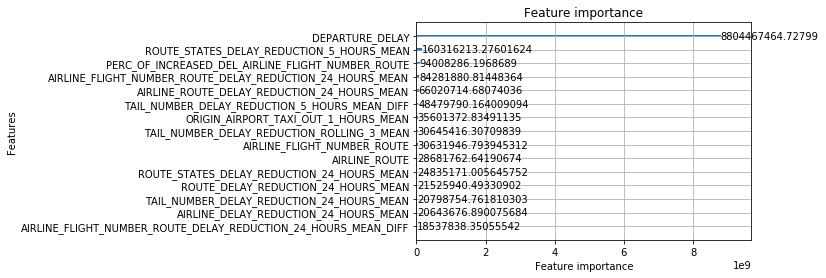

In [7]:
%%time
train_lgb = lgb.Dataset(train.drop(['ARRIVAL_DELAY'], axis = 1), label = train.ARRIVAL_DELAY, 
                       categorical_feature=categorical)

params = {'boosting': ['gbdt'],
        'num_leaves': 109,
        'max_depth': 6,
        'min_child_weight': 8.305720294136718,
        'learning_rate': 0.1,
        'reg_lambda': 9.113118067549191,
        'reg_alpha': 0.7825401736537646,
        'bagging_fraction': 0.8916785668592089,
        'bagging_freq': 1,
        'bagging_seed': 222,
        'feature_fraction': 0.7284579815314179,
        'feature_fraction_seed': 222,
        'objective': 'regression',
        'metric': 'rmse'}
    
lgb_model = lgb.train(params, train_lgb, num_boost_round = 229, categorical_feature=categorical)

y_pred = lgb_model.predict(test)
print(rmse(y_pred, test.ARRIVAL_DELAY))
print(lgb.plot_importance(lgb_model, max_num_features=15, importance_type = 'gain'))

We have managed to outperform RMSE our benchmark from 13.5 to 11.7.

As we can see departure delay is definitely the best feature for predicting arrival delay. The other features that correct the error of departure delay are:
* an average delay reduction from the last 5 hours grouped by a state of route
* a percentage of flights with increased delay reduction grouped by a particular flight
* an average delay reduction from the last 24 hours grouped by a particular flight
* an average delay reduction from the last 24 hours grouped by a particular route of airlines
* a difference of an average delay from the last 5 hours compared to an average flight grouped by a unique aircraft
* an average taxi out from the last 1 hours grouped by an origin airport
* an average delay reduction of the last 3 flights grouped by a unique aircraft
* an average delay reduction of a particular flight
* an average delay reduction of a particular route of airlines
* an average delay reduction from the last 24 hours grouped by a particular route of airlines.

As we can see the most useful seem to be the features related to a route of an airline and a particular flight. Below there are presented all the features with a decreasing impact on arrival delay.

In [8]:
feature_imp = pd.DataFrame({'Value':lgb_model.feature_importance(importance_type = 'gain'),
                            'Feature':train.drop('ARRIVAL_DELAY', axis = 1).columns})\
                            .sort_values('Value', ascending = False).reset_index(drop = True)

feature_imp

,Value,Feature
0,8.804467e+09,DEPARTURE_DELAY
1,1.603162e+08,ROUTE_STATES_DELAY_REDUCTION_5_HOURS_MEAN
2,9.400829e+07,PERC_OF_INCREASED_DEL_AIRLINE_FLIGHT_NUMBER_ROUTE
3,8.428188e+07,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_24...
4,6.602071e+07,AIRLINE_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN
5,4.847979e+07,TAIL_NUMBER_DELAY_REDUCTION_5_HOURS_MEAN_DIFF
6,3.560137e+07,ORIGIN_AIRPORT_TAXI_OUT_1_HOURS_MEAN
7,3.064542e+07,TAIL_NUMBER_DELAY_REDUCTION_ROLLING_3_MEAN
8,3.063195e+07,AIRLINE_FLIGHT_NUMBER_ROUTE
9,2.868176e+07,AIRLINE_ROUTE


Let's now choose from only the most important 55 variables.

In [9]:
top_55_vars = list(feature_imp.Feature.head(55)) + ['ARRIVAL_DELAY']
top_55_vars

['DEPARTURE_DELAY',
 'ROUTE_STATES_DELAY_REDUCTION_5_HOURS_MEAN',
 'PERC_OF_INCREASED_DEL_AIRLINE_FLIGHT_NUMBER_ROUTE',
 'AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN',
 'AIRLINE_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN',
 'TAIL_NUMBER_DELAY_REDUCTION_5_HOURS_MEAN_DIFF',
 'ORIGIN_AIRPORT_TAXI_OUT_1_HOURS_MEAN',
 'TAIL_NUMBER_DELAY_REDUCTION_ROLLING_3_MEAN',
 'AIRLINE_FLIGHT_NUMBER_ROUTE',
 'AIRLINE_ROUTE',
 'ROUTE_STATES_DELAY_REDUCTION_24_HOURS_MEAN',
 'ROUTE_DELAY_REDUCTION_24_HOURS_MEAN',
 'TAIL_NUMBER_DELAY_REDUCTION_24_HOURS_MEAN',
 'AIRLINE_DELAY_REDUCTION_24_HOURS_MEAN',
 'AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF',
 'TAIL_NUMBER',
 'ORIGIN_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN',
 'ROUTE_STATES',
 'ORIGIN_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN_DIFF',
 'TAIL_NUMBER_DELAY_REDUCTION_5_HOURS_MEAN',
 'AIRLINE_DELAY_REDUCTION_5_HOURS_MEAN_DIFF',
 'AIRLINE_DELAY_REDUCTION_5_HOURS_MEAN',
 'ROUTE',
 'AIRLINE',
 'DESTINATION_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN',

In [10]:
train = train[top_55_vars]
test = test[top_55_vars]

We should also update our categorical variables.

In [12]:
categorical = ['AIRLINE_FLIGHT_NUMBER_ROUTE', 'AIRLINE_ROUTE', 'TAIL_NUMBER', 'ROUTE_STATES', 'ROUTE', 'AIRLINE', 
              'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE_HH', 'STATE_ORIGIN']

Let's now examine how a removal of half of the variables will affect our performance.

In [13]:
%%time
train_lgb = lgb.Dataset(train.drop(['ARRIVAL_DELAY'], axis = 1), label = train.ARRIVAL_DELAY, 
                       categorical_feature=categorical)
num_boost_round = 300
lgb_model = lgb.cv(params, train_lgb, nfold = 5, verbose_eval = 50, categorical_feature=categorical,
                   num_boost_round=num_boost_round, early_stopping_rounds=20, seed = 222, stratified = False, shuffle = False)
print(len(lgb_model['rmse-mean']))
print(lgb_model['rmse-mean'][-1])

[50]	cv_agg's rmse: 11.567 + 0.660833
[100]	cv_agg's rmse: 11.4222 + 0.647281
[150]	cv_agg's rmse: 11.3997 + 0.641997
[200]	cv_agg's rmse: 11.3966 + 0.641453
196
11.396131460098674
Wall time: 1min 15s


As we can see the performance of our cross-validatation has improved a little and a number of iterations to achieve that has decreased. Let's make predictions on the same parameters with a decreased number of iterarations.

11.43132503023745
AxesSubplot(0.125,0.125;0.775x0.755)
Wall time: 20.3 s


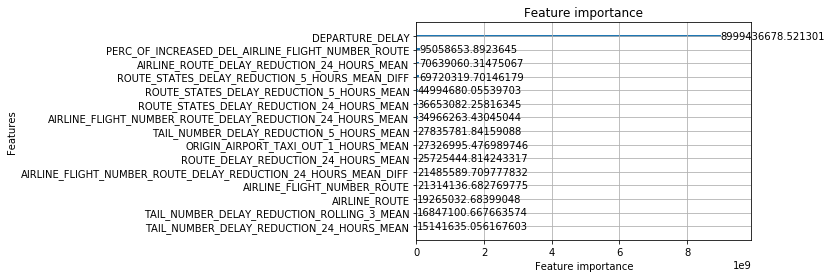

In [14]:
%%time
train_lgb = lgb.Dataset(train.drop(['ARRIVAL_DELAY'], axis = 1), label = train.ARRIVAL_DELAY, 
                       categorical_feature=categorical)

params = {'boosting': ['gbdt'],
        'num_leaves': 109,
        'max_depth': 6,
        'min_child_weight': 8.305720294136718,
        'learning_rate': 0.1,
        'reg_lambda': 9.113118067549191,
        'reg_alpha': 0.7825401736537646,
        'bagging_fraction': 0.8916785668592089,
        'bagging_freq': 1,
        'bagging_seed': 222,
        'feature_fraction': 0.7284579815314179,
        'feature_fraction_seed': 222,
        'objective': 'regression',
        'metric': 'rmse'}

lgb_model = lgb.train(params, train_lgb, num_boost_round = 196, categorical_feature=categorical)
y_pred = lgb_model.predict(test)
print(rmse(y_pred, test.ARRIVAL_DELAY))
print(lgb.plot_importance(lgb_model, max_num_features=15, importance_type = 'gain'))

A new set of the most important features, apart from departure delay are:
* a percentage of flights with increased delay reduction grouped by a particular flight
* an average delay reduction from the last 24 hours grouped by a particular route of airlines
* a difference of an average delay from the last 5 hours compared to an average flight grouped by a state of route
* an average delay reduction from the last 5 hours grouped by a particular route of route
* an average delay reduction from the last 24 hours grouped by a particular route of route
* an average delay reduction from the last 24 hours grouped by a particular flight
* an average delay reduction from the last 5 hours grouped by a unique aircraft
* an average taxi out from last 1 hours grouped by an origin airport
* an average delay reduction from the last 24 hours grouped by a particular route
* a difference of an average delay from the last 24 hours compared to an average flight grouped by a particular flight.

Those features are very similar to the features obtained from the previous model with a few differences. There are both columns that are not prone to overfitting, such as the columns based on states of route, as well as the columns based on the individual repetitive flights or aircrafts.

We have removed half ot the variables and the model became more simplified. It finishes in a fewer number of iterations (196 instead of 229) and the performance has improved a little bit:
* from 11.698 to 11.431 on the test set
* from  to 11.405 to 11.396 on the cv.

The difference in cv results is very small, whereas the difference is more visible on new data. It seems that removing half of the variables prevented model from too much overfitting to train data, making cv and test performance more consistent.

# SUMMARY

We have managed to improve the RMSE score of arrival delay on test data from 13.5 (expecting the same arrival delay as departure delay) to 11.4 so our predictions are averagly more acurately by about 2 minutes.

The created features are easily interpretable and indicate mainly the influence of recent flights on the nearest fligts grouped by some columns such as airports, routes or aircrafts.